# Use Convolutional Neural Network for Biome Classification
-- by jenny
from
[https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py)  
[A Guide to TF Layers: Building a Convolutional Neural Network Contents](https://www.tensorflow.org/tutorials/layers)  


denote number of data  
mesa size:  10015  
forest size:  10047  
desert size:  10106  
jungle size:  10238  
eh size:  7364  
training size: 42993  
test size: 4777  
total size:  47770

In [8]:
%pylab inline
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [1]:

IMAGE_HEIGHT = 200
IMAGE_WIDTH = 320
NUM_CHANNELS = 3

# Parameters
BATCH_SIZE = 10
TEST_BATCH_SIZE = 10
LEARNING_RATE = 0.001
display_step = 200
train_size= 42993
test_size =4777
# Network Parameters
NUM_LABELS = 5 # mesa forest desert jungle eh


In [2]:
labels ={"mesa":0, "forest":1,"desert":2,"jungle":3, "eh":4}
tfrecords_train_filename = '/notebooks/Minecraft-AI/mc-data/mesa_forest_desert_jungle_eh_train.tfrecords'
tfrecords_test_filename = '/notebooks/Minecraft-AI/mc-data/mesa_forest_desert_jungle_eh_test.tfrecords'

## load data
### healper function for reading and decoding data in tfrecord file

In [3]:

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
#         'mask_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
#     annotation = tf.decode_raw(features['mask_raw'], tf.uint8)
    label =  tf.cast(features['label'], tf.int32)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    #tf.stack equal to tf.stack([x, y, z]) = np.asarray([x, y, z])
    image_shape = tf.stack([height, width, 3])
    
    image = tf.reshape(image, image_shape)
    
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
        
    images,label = tf.train.shuffle_batch( [resized_image,label],
                                                 batch_size=BATCH_SIZE,
                                                 capacity=30000,
                                                 num_threads=3,
                                                 min_after_dequeue=10)
    
    return images, label

## load validation and test data

### helper functions

In [4]:
def scaleImg(img):
    img = img.astype(np.float32)
    return (img-(255/2.0)) / 255

In [5]:
def convertLabel(lab):
    return (numpy.arange(NUM_LABELS) == lab[:, None]).astype(numpy.float32)

In [6]:
def load_data(tfrecords_filename, img_num):
    queue = tf.train.string_input_producer(
    [tfrecords_filename])
    init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
    image, label = read_and_decode(queue)
    with tf.Session()  as s:
        s.run(init_op)
    
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
    
        img, lab = s.run([image, label])
        data = scaleImg(img)
        labels = convertLabel(lab)

    
        for i in range(img_num//(BATCH_SIZE)):
            img, lab = s.run([image, label])
            batch_data = scaleImg(img)
            batch_labels = convertLabel(lab)
            data = np.concatenate((data, batch_data),axis=0)
            labels = np.concatenate((labels,batch_labels), axis=0)
        
        coord.request_stop()
        coord.join(threads)
    return data,labels


### load data

In [9]:
validation_data, validation_labels = load_data(tfrecords_train_filename, 300)
print "done~"
# test_data, test_labels = load_data(tfrecords_test_filename, 300)
# print "done!!"

done~


## Config CNN

If your input is of size w1\*h1\*d1 and the size of the filter is f\*f with stride S. Then the output sizes w2\*h2\*d2 will be:
```
w2= (w1-f)/S +1

h2=(h1-f)/S +1

d2=d1
```

In [10]:
# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step, which we'll write once we define the graph structure.
train_data_node = tf.placeholder(
  tf.float32,
  shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS), name="train_data_node")
train_labels_node = tf.placeholder(tf.float32,
                                   shape=(BATCH_SIZE, NUM_LABELS))
# For the validation and test data, we'll just hold the entire dataset in
# one constant node.
validation_data_node = tf.constant(validation_data)
test_data_node = tf.placeholder(
  tf.float32,
  shape=(TEST_BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS), name="test_data_node")

In [11]:
# The random seed that defines initialization.
SEED = 42
# The variables below hold all the trainable weights. For each, the
# parameter defines how the variables will be initialized.
conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))
conv2_weights = tf.Variable(
  tf.truncated_normal([5, 5, 32, 64],
                      stddev=0.1,
                      seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))
fc1_weights = tf.Variable(  # fully connected, depth 512.
  tf.truncated_normal([IMAGE_HEIGHT // 4 * IMAGE_WIDTH // 4 * 64, 512],
                      stddev=0.1,
                      seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
fc2_weights = tf.Variable(
  tf.truncated_normal([512, NUM_LABELS],
                      stddev=0.1,
                      seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))

print('Done')

Done


In [12]:
def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')

    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))

    # Max pooling. The kernel size spec ksize also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

print('Done')

Done


In [13]:
# 2D convolution
def conv2d(X, W):
    return tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')

# Max Pooling
def max_pool_2x2(X):
    return tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [14]:
# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
tf.identity(logits, name="logits")
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
  labels=train_labels_node, logits=logits))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  LEARNING_RATE,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.AdamOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits, name = "train_prediction")
# # We'll compute them only once in a while by calling their {eval()} method.
validation_prediction = tf.nn.softmax(model(validation_data_node))
test_prediction = tf.nn.softmax(model(test_data_node), name="test_prediction")
print('Done')

Done


### load training data

In [15]:
# Even when reading in multiple threads, share the filename
# queue.
train_queue = tf.train.string_input_producer(
    [tfrecords_train_filename, tfrecords_test_filename])
print "read_and_decode"
image,  label = read_and_decode(train_queue)
# init_op = tf.group(tf.global_variables_initializer(),
#                    tf.local_variables_initializer())
print(image.shape)

read_and_decode
(10, 200, 320, 3)


In [16]:
# # Create a new interactive session that we'll use in
# # subsequent code cells.
s = tf.InteractiveSession()

In [17]:
# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

In [18]:
# Initialize all the variables we defined above.
tf.global_variables_initializer().run()

In [19]:
# s.run(init_op)
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

In [20]:
saver = tf.train.Saver() # add saver to save the training

In [21]:
img, lab = s.run([image,label])

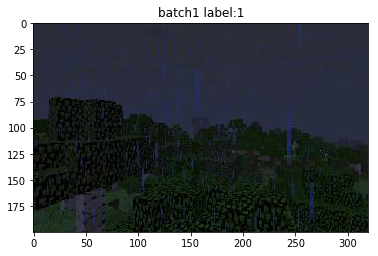

In [22]:
plt.title("batch{} label:{}".format(1,lab[0]))
plt.imshow(img[0,:,:,:])
plt.show()

### try first training iter

In [23]:
batch_labels = convertLabel(lab)
batch_data = scaleImg(img)
s.run(optimizer, feed_dict={train_data_node: batch_data, train_labels_node:batch_labels })
# Run the graph and fetch some of the nodes.
_, l, lr, predictions = s.run(
  [optimizer, loss, learning_rate, train_prediction],
  feed_dict={train_data_node: scaleImg(img), train_labels_node: convertLabel(lab)})

print('Done')

Done


In [24]:
print(predictions[0])

[  9.99998569e-01   0.00000000e+00   0.00000000e+00   1.39318411e-06
   0.00000000e+00]


In [25]:
# The highest probability in the first entry.
print('First prediction', numpy.argmax(predictions[0]))

# But, predictions is actually a list of BATCH_SIZE probability vectors.
print(predictions.shape)

# So, we'll take the highest probability for each vector.
print('All predictions', numpy.argmax(predictions, 1))

('First prediction', 0)
(10, 5)
('All predictions', array([0, 3, 3, 3, 3, 3, 0, 3, 3, 3]))


Now we can compare the predicted and label classes to compute the error rate and confusion matrix for this batch.

0.4


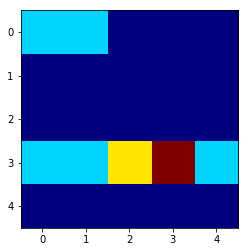

In [26]:
correct = numpy.sum(numpy.argmax(predictions, 1) == numpy.argmax(batch_labels, 1))
total = predictions.shape[0]

print(float(correct) / float(total))

confusions = numpy.zeros([NUM_LABELS,NUM_LABELS], numpy.float32)
bundled = zip(numpy.argmax(predictions, 1), numpy.argmax(batch_labels, 1))
for predicted, actual in bundled:
      confusions[predicted, actual] += 1

plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

Now let's wrap this up into our scoring function.

In [27]:
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([NUM_LABELS, NUM_LABELS], np.float32)
    bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

print('Done')

Done


We'll need to train for some time to actually see useful predicted values. Let's define a loop that will go through our data. We'll print the loss and error periodically.

Here, we want to iterate over the entire data set rather than just the first batch, so we'll need to slice the data to that end.

(One pass through our training set will take some time on a CPU, so be patient if you are executing this notebook.)

In [28]:
# batch_loss_list = []
# batch_error_rate = []
# step_list = []
# va_error_list = []
# learning_rate_list = []

In [28]:
# Train over training set.
steps = train_size // BATCH_SIZE

for step in range(steps):
    img, lab = s.run([image, label])
    batch_labels = convertLabel(lab)
    batch_data = scaleImg(img)
    # This dictionary maps the batch data (as a numpy array) to the
    # node in the graph it should be fed to.
    feed_dict = {train_data_node: batch_data,
                 train_labels_node: batch_labels}
    # Run the graph and fetch some of the nodes.
    _, l, lr, predictions = s.run(
      [optimizer, loss, learning_rate, train_prediction],
      feed_dict=feed_dict)
    
    # Print out the loss periodically.
    if step % display_step == 0:
        error, _ = error_rate(predictions, batch_labels)
        va_error = error_rate(
              validation_prediction.eval(), validation_labels)[0]
#         batch_loss_list.append(l)
#         batch_error_rate.append(error)
#         learning_rate_list.append(lr)
#         va_error_list.append(va_error)
#         step_list.append(step)
        print('Step %d of %d' % (step, steps))
        print('Mini-batch loss: %.5f Error: %.5f Learning rate: %.5f' % (l, error, lr))
        print('Validation error: %.1f%%' % va_error)

Step 0 of 4299
Mini-batch loss: 482.40057 Error: 80.00000 Learning rate: 0.00100
Validation error: 62.6%
Step 200 of 4299
Mini-batch loss: 139.54459 Error: 30.00000 Learning rate: 0.00100
Validation error: 31.6%
Step 400 of 4299
Mini-batch loss: 99.25084 Error: 20.00000 Learning rate: 0.00100
Validation error: 13.5%
Step 600 of 4299
Mini-batch loss: 73.02122 Error: 10.00000 Learning rate: 0.00100
Validation error: 11.0%
Step 800 of 4299
Mini-batch loss: 54.07351 Error: 10.00000 Learning rate: 0.00100
Validation error: 27.4%
Step 1000 of 4299
Mini-batch loss: 40.33794 Error: 0.00000 Learning rate: 0.00100
Validation error: 23.5%
Step 1200 of 4299
Mini-batch loss: 30.63315 Error: 10.00000 Learning rate: 0.00100
Validation error: 10.3%
Step 1400 of 4299
Mini-batch loss: 23.22872 Error: 10.00000 Learning rate: 0.00100
Validation error: 9.7%
Step 1600 of 4299
Mini-batch loss: 17.97429 Error: 20.00000 Learning rate: 0.00100
Validation error: 10.3%
Step 1800 of 4299
Mini-batch loss: 13.35056 

In [29]:
save_path = saver.save(s, "/notebooks/Minecraft-AI/mc-data/model/model.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: /notebooks/Minecraft-AI/mc-data/model/model.ckpt


# load test data for testing

In [30]:
steps = test_size//TEST_BATCH_SIZE
predictions = []
test_labels = []
print "total steps:", steps
for step in range(steps):
    img, lab = s.run([image, label])
    index = 0
    for i in range(BATCH_SIZE//TEST_BATCH_SIZE):
        batch_data = scaleImg(img[index:index+TEST_BATCH_SIZE])
        batch_labels = convertLabel(lab[index:index+TEST_BATCH_SIZE])
        predictions.extend( s.run(
              [test_prediction],
              feed_dict={test_data_node:batch_data})[0])
        test_labels.append(batch_labels)
        index = index+TEST_BATCH_SIZE
    if step % display_step == 0:
        print "current step:", step
        


total steps: 477
current step: 0
current step: 200
current step: 400


In [31]:
predictions = np.array(predictions)
test_labels = np.array(test_labels).reshape(len(test_labels)*TEST_BATCH_SIZE,NUM_LABELS)

test_error, confusions = error_rate(predictions, test_labels)

In [32]:
predictions[0]

array([  1.00000000e+00,   1.12112346e-13,   2.86393465e-15,
         1.39484343e-16,   5.77991439e-11], dtype=float32)

Test error: 6.6%


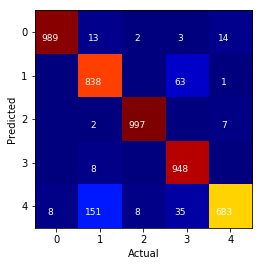

In [33]:
# test_error, confusions = error_rate(test_prediction.eval(), test_labels)
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

labels ={"mesa":0, "forest":1,"desert":2,"jungle":3, "eh":4}

In [34]:
coord.request_stop()
coord.join(threads)
s.close()

In [ ]:
fig = plt.figure(figsize=(20,15))
fig.add_subplot(221)
plt.title("batch loss")
plt.plot(step_list,batch_loss_list ,label="batch loss")
fig.add_subplot(222)
plt.title("batch error rate")
plt.plot(step_list, batch_error_rate ,label="batch error rate")
fig.add_subplot(223)
plt.title("validation error rate")
plt.plot(step_list, va_error_list,label="validation error rate")
fig.add_subplot(224)
plt.title("learning rate")
plt.plot(step_list, learning_rate_list, label="learning rate")
plt.show()

# visualization

In [37]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [38]:
show_graph(tf.get_default_graph().as_graph_def())

In [ ]:
import pydot
from itertools import chain
def tf_graph_to_dot(in_graph):
    dot = pydot.Dot()
    dot.set('rankdir', 'LR')
    dot.set('concentrate', True)
    dot.set_node_defaults(shape='record')
    all_ops = in_graph.get_operations()
    all_tens_dict = {k: i for i,k in enumerate(set(chain(*[c_op.outputs for c_op in all_ops])))}
    for c_node in all_tens_dict.keys():
        node = pydot.Node(c_node.name)#, label=label)
        dot.add_node(node)
    for c_op in all_ops:
        for c_output in c_op.outputs:
            for c_input in c_op.inputs:
                dot.add_edge(pydot.Edge(c_input.name, c_output.name))
    return dot

In [31]:
def TB(cleanup=False):
    import webbrowser
    webbrowser.open('http://127.0.1.1:6006')

    !tensorboard --logdir="logs"

    if cleanup:
        !rm -R logs/

In [32]:
TB()

Starting TensorBoard 47 at http://0.0.0.0:6006
(Press CTRL+C to quit)
^C
